# Tobig's 정규세션 10주차 음성 과제 1

- 다음 5개의 질문에 **단답형**으로 답해주세요.

## Q1. 시간에 따른 소리의 진폭을 나타낸 그래프를 영어로 무엇이라고 하나요?

A1. Waveform

## Q2. 샘플링 주파수는 원래 신호의 최고 주파수의 2배 이상이 되어야 원래 신호로 복구할 수 있다는 정리의 이름을 영어로 무엇이라고 하나요?

A2. Nyquist-Shannon Sampling Theorem

## Q3. 소리를 시각화한 것으로, 단시간 푸리에 변환을 통해 시간, 주파수, 진폭 정보를 모두 담고 있는 것을 영어로 무엇이라고 하나요?

A3. Spectrogram

## Q4. 인간의 청각 시스템에 맞게 Mel-scale을 적용하여 주파수를 조절한 스펙트로그램을 영어로 무엇이라고 하나요?

A4. Mel-Spectrogram

## Q5. Speech 정규세션 강의자가 수업 시작할 때 5명을 랜덤으로 지목하여 질문하겠다고 했으나, 실제로는 그보다 적은 n명에게 질문하였습니다. n의 값은 무엇입니까?

A5. 0

# Tobig's 정규세션 10주차 음성 과제 2

1. train 폴더 내의 2,000개 음원을 이용하여 음성 분류 모델을 만들어보세요.
2. 음성 분류 모델을 이용하여 test 폴더 내의 300개 음원을 분류하세요.

In [248]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchaudio

from glob import glob
import random
import os
from tqdm import tqdm

import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import accuracy_score

In [143]:
config = {
    'epochs':15,
    'lr': 1e-4,
    'batch_size': 64,
    'val_ratio': 0.1,
    'seed': 42,
    'device':torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}


In [131]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config['seed'])

In [132]:
train_path_list,val_path_list = train_test_split(glob('./train/*'),test_size=config['val_ratio'],random_state=config['seed'], shuffle=True)
test_path_list = sorted(glob('./test/*'), key=lambda x: int(x.split('/')[-1].split('.')[0]))
test_path_list[:10]

['./test/0000.wav',
 './test/0001.wav',
 './test/0002.wav',
 './test/0003.wav',
 './test/0004.wav',
 './test/0005.wav',
 './test/0006.wav',
 './test/0007.wav',
 './test/0008.wav',
 './test/0009.wav']

In [255]:
class AudioDataset(Dataset):
    def __init__(self, path_list, is_train = True,use_specto = True,pad = 50000):
        
        self.path_list = path_list
        self.is_train = is_train
        self.use_specto = use_specto
        self.pad = pad
        self.transform = torchaudio.transforms.MelSpectrogram(n_mels=64)

    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self, idx):
        ret = {}

        path = self.path_list[idx]
        data,sr = torchaudio.load(path)[0]
        if self.pad > len(data):
            padding = self.pad - len(data)        
            data = F.pad(data,(0,padding),'constant',0)
        else:
            data = data[:self.pad]

        if self.use_specto:
            data = self.transform(data)

        ret['X'] = data

        if self.is_train:
            label = int(path.split('/')[-1].split('.')[0][-1])
            ret['y'] = label

        return ret  
    
train_dataset = AudioDataset(train_path_list,is_train = True,use_specto = True)
train_loader = DataLoader(train_dataset,batch_size=config['batch_size'],shuffle=True,num_workers=4)

val_dataset = AudioDataset(val_path_list,is_train=True,use_specto=True)
val_loader = DataLoader(val_dataset,batch_size=config['batch_size'],shuffle=False,num_workers=4)

test_dataset = AudioDataset(test_path_list,is_train=False,use_specto=True)
test_loader = DataLoader(test_dataset,batch_size=config['batch_size'],shuffle=False,num_workers=4)   

torch.Size([64, 251])


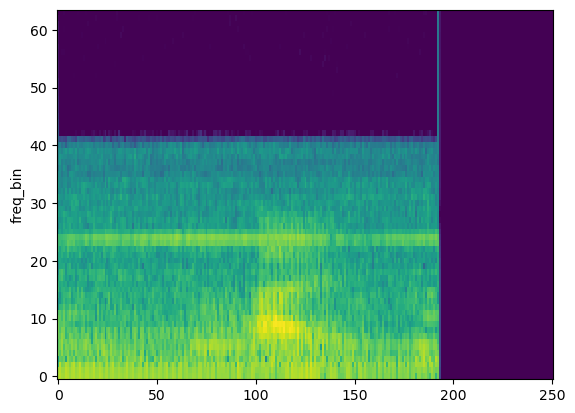

In [256]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

plot_spectrogram(next(iter(train_loader))['X'][10].numpy())
print(next(iter(train_loader))['X'][10].size())

In [280]:

class Trainer():
    def __init__(self,model,config):

        self.config = config
        self.model = model.to(self.config['device'])
        self.optimizer = torch.optim.AdamW(model.parameters(),config['lr'],weight_decay=0.2)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,mode='min',patience=3,verbose=True)

        self.criterion = nn.CrossEntropyLoss()
        self.epoch = 0

        self.loss_dict = {}

    def train(self,train_loader,val_loader):

        for epoch in range(self.config['epochs']):
            self.model.train()
            for step,data in enumerate(tqdm(train_loader)):
                
                
                y = data['y']
                y = y.type(torch.LongTensor).to(self.config['device'])
                X = data['X'].to(self.config['device']).float()

                outputs = self.model(X)

                loss = self.criterion(outputs,y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            val_loss,val_acc = self.validation(val_loader)
            self.scheduler.step(val_loss)
            self.epoch += 1

            print(f'Epoch: {self.epoch} Val Loss: {val_loss} Val Acc: {val_acc}')

    def validation(self,val_loader):

        sum_loss = []
        logit = []
        gt = []
        self.model.eval()
        for step,data in enumerate(val_loader):

            with torch.no_grad():
                y = data['y']
                y = y.type(torch.LongTensor).to(self.config['device'])
                X = data['X'].to(self.config['device']).float()

                outputs = self.model(X)

                loss = self.criterion(outputs,y)
                sum_loss.append(loss.item())

                logit.extend(outputs.argmax(1).detach().cpu().numpy())

                gt.extend(y.detach().cpu().numpy())
        logit = np.array(logit)
        gt = np.array(gt)
        accuracy = accuracy_score(gt,logit)
        sum_loss = np.mean(sum_loss)
        return sum_loss,accuracy
    
    def test(self,test_loader):

        logit = torch.FloatTensor().to(self.config['device'])
        self.model.eval()
        for step,data in enumerate(tqdm(test_loader)):

            with torch.no_grad():
                
                X = data['X'].to(self.config['device']).float()

                outputs = self.model(X)
                logit = torch.cat((outputs,logit),dim=0)

        result = torch.argmax(logit,dim=1)
        return result,logit



In [281]:
# Using Waveform encoder
class WaveAudioClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(1,32,kernel_size=64,stride=16)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32,64,kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(4)

        self.conv3 = nn.Conv1d(64,128,kernel_size=3)
        self.bn3 = nn.BatchNorm1d(128)

        self.conv4 = nn.Conv1d(128,256,kernel_size=3)
        self.bn4 = nn.BatchNorm1d(256)

        self.conv5 = nn.Conv1d(256,512,kernel_size=3)
        self.bn5 = nn.BatchNorm1d(512)

        self.linear = nn.Linear(512,10)

    def forward(self,x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))

        x = F.avg_pool1d(x,kernel_size=x.size()[-1])
        x = x.squeeze(2)
        x = self.linear(x)

        return x

In [282]:
train_dataset = AudioDataset(train_path_list,is_train = True,use_specto = False,pad=60000)
train_loader = DataLoader(train_dataset,batch_size=config['batch_size'],shuffle=True,num_workers=4)

val_dataset = AudioDataset(val_path_list,is_train=True,use_specto=False,pad=60000)
val_loader = DataLoader(val_dataset,batch_size=config['batch_size'],shuffle=False,num_workers=4)

test_dataset = AudioDataset(test_path_list,is_train=False,use_specto=False,pad=60000)
test_loader = DataLoader(test_dataset,batch_size=config['batch_size'],shuffle=False,num_workers=4)     

In [287]:
config = {
    'epochs':50,
    'lr': 1e-4,
    'batch_size': 64,
    'val_ratio': 0.1,
    'seed': 42,
    'device':torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}


In [288]:
model = WaveAudioClassifier()
trainer = Trainer(model,config)
trainer.train(train_loader,val_loader)

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 31.83it/s]


Epoch: 1 Val Loss: 2.3019009232521057 Val Acc: 0.07


100%|██████████| 29/29 [00:00<00:00, 33.33it/s]


Epoch: 2 Val Loss: 2.15116548538208 Val Acc: 0.275


100%|██████████| 29/29 [00:00<00:00, 33.21it/s]


Epoch: 3 Val Loss: 1.9305516481399536 Val Acc: 0.365


100%|██████████| 29/29 [00:00<00:00, 32.53it/s]


Epoch: 4 Val Loss: 1.7624793350696564 Val Acc: 0.51


100%|██████████| 29/29 [00:00<00:00, 33.21it/s]


Epoch: 5 Val Loss: 1.6842075288295746 Val Acc: 0.485


100%|██████████| 29/29 [00:00<00:00, 33.39it/s]


Epoch: 6 Val Loss: 1.5920221507549286 Val Acc: 0.54


100%|██████████| 29/29 [00:00<00:00, 32.00it/s]


Epoch: 7 Val Loss: 1.4831960797309875 Val Acc: 0.535


100%|██████████| 29/29 [00:00<00:00, 32.75it/s]


Epoch: 8 Val Loss: 1.4263410866260529 Val Acc: 0.625


100%|██████████| 29/29 [00:00<00:00, 32.98it/s]


Epoch: 9 Val Loss: 1.4271210432052612 Val Acc: 0.59


100%|██████████| 29/29 [00:00<00:00, 33.61it/s]


Epoch: 10 Val Loss: 1.4016238152980804 Val Acc: 0.6


100%|██████████| 29/29 [00:00<00:00, 32.60it/s]


Epoch: 11 Val Loss: 1.3665842115879059 Val Acc: 0.61


100%|██████████| 29/29 [00:00<00:00, 34.11it/s]


Epoch: 12 Val Loss: 1.2610182762145996 Val Acc: 0.645


100%|██████████| 29/29 [00:00<00:00, 33.96it/s]


Epoch: 13 Val Loss: 1.223414957523346 Val Acc: 0.635


100%|██████████| 29/29 [00:00<00:00, 33.31it/s]


Epoch: 14 Val Loss: 1.2207351624965668 Val Acc: 0.65


100%|██████████| 29/29 [00:00<00:00, 33.44it/s]


Epoch: 15 Val Loss: 1.1806216835975647 Val Acc: 0.67


100%|██████████| 29/29 [00:00<00:00, 33.73it/s]


Epoch: 16 Val Loss: 1.2230213582515717 Val Acc: 0.65


100%|██████████| 29/29 [00:00<00:00, 33.23it/s]


Epoch: 17 Val Loss: 1.2487677037715912 Val Acc: 0.65


100%|██████████| 29/29 [00:00<00:00, 33.62it/s]


Epoch: 18 Val Loss: 1.1406330168247223 Val Acc: 0.675


100%|██████████| 29/29 [00:00<00:00, 33.88it/s]


Epoch: 19 Val Loss: 1.1362531185150146 Val Acc: 0.67


100%|██████████| 29/29 [00:00<00:00, 34.14it/s]


Epoch: 20 Val Loss: 1.0848339200019836 Val Acc: 0.695


100%|██████████| 29/29 [00:00<00:00, 33.91it/s]


Epoch: 21 Val Loss: 1.0682547986507416 Val Acc: 0.68


100%|██████████| 29/29 [00:00<00:00, 33.21it/s]


Epoch: 22 Val Loss: 1.0088408887386322 Val Acc: 0.71


100%|██████████| 29/29 [00:00<00:00, 33.47it/s]


Epoch: 23 Val Loss: 0.9605445563793182 Val Acc: 0.71


100%|██████████| 29/29 [00:00<00:00, 33.40it/s]


Epoch: 24 Val Loss: 0.9887281656265259 Val Acc: 0.72


100%|██████████| 29/29 [00:00<00:00, 33.43it/s]


Epoch: 25 Val Loss: 1.0592361092567444 Val Acc: 0.69


100%|██████████| 29/29 [00:00<00:00, 33.72it/s]


Epoch: 26 Val Loss: 1.0223279148340225 Val Acc: 0.685


100%|██████████| 29/29 [00:00<00:00, 33.49it/s]


Epoch: 27 Val Loss: 0.9519897848367691 Val Acc: 0.735


100%|██████████| 29/29 [00:00<00:00, 33.62it/s]


Epoch: 28 Val Loss: 0.9899541884660721 Val Acc: 0.725


100%|██████████| 29/29 [00:00<00:00, 33.59it/s]


Epoch: 29 Val Loss: 0.916040763258934 Val Acc: 0.69


100%|██████████| 29/29 [00:00<00:00, 32.91it/s]


Epoch: 30 Val Loss: 0.92258720099926 Val Acc: 0.735


100%|██████████| 29/29 [00:00<00:00, 32.95it/s]


Epoch: 31 Val Loss: 0.9875016361474991 Val Acc: 0.745


100%|██████████| 29/29 [00:00<00:00, 33.34it/s]


Epoch: 32 Val Loss: 0.9133343249559402 Val Acc: 0.745


100%|██████████| 29/29 [00:00<00:00, 32.99it/s]


Epoch: 33 Val Loss: 0.8665518462657928 Val Acc: 0.75


100%|██████████| 29/29 [00:00<00:00, 33.50it/s]


Epoch: 34 Val Loss: 0.8481748253107071 Val Acc: 0.73


100%|██████████| 29/29 [00:00<00:00, 33.67it/s]


Epoch: 35 Val Loss: 0.8633184880018234 Val Acc: 0.73


100%|██████████| 29/29 [00:00<00:00, 33.58it/s]


Epoch: 36 Val Loss: 0.7917674705386162 Val Acc: 0.715


100%|██████████| 29/29 [00:00<00:00, 33.10it/s]


Epoch: 37 Val Loss: 0.8487184196710587 Val Acc: 0.73


100%|██████████| 29/29 [00:00<00:00, 32.11it/s]


Epoch: 38 Val Loss: 0.853710487484932 Val Acc: 0.74


100%|██████████| 29/29 [00:00<00:00, 33.54it/s]


Epoch: 39 Val Loss: 0.8605282157659531 Val Acc: 0.76


100%|██████████| 29/29 [00:00<00:00, 33.80it/s]


Epoch 00040: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 40 Val Loss: 0.8934561312198639 Val Acc: 0.705


100%|██████████| 29/29 [00:00<00:00, 33.79it/s]


Epoch: 41 Val Loss: 0.794471263885498 Val Acc: 0.765


100%|██████████| 29/29 [00:00<00:00, 33.81it/s]


Epoch: 42 Val Loss: 0.799965500831604 Val Acc: 0.77


100%|██████████| 29/29 [00:00<00:00, 33.53it/s]


Epoch: 43 Val Loss: 0.7860328555107117 Val Acc: 0.765


100%|██████████| 29/29 [00:00<00:00, 32.96it/s]


Epoch: 44 Val Loss: 0.786554217338562 Val Acc: 0.775


100%|██████████| 29/29 [00:00<00:00, 33.60it/s]


Epoch: 45 Val Loss: 0.7602411657571793 Val Acc: 0.765


100%|██████████| 29/29 [00:00<00:00, 33.84it/s]


Epoch: 46 Val Loss: 0.7955960035324097 Val Acc: 0.755


100%|██████████| 29/29 [00:00<00:00, 34.11it/s]


Epoch: 47 Val Loss: 0.7647082209587097 Val Acc: 0.76


100%|██████████| 29/29 [00:00<00:00, 33.31it/s]


Epoch: 48 Val Loss: 0.7796114534139633 Val Acc: 0.77


100%|██████████| 29/29 [00:00<00:00, 33.17it/s]


Epoch 00049: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 49 Val Loss: 0.7829148024320602 Val Acc: 0.77


100%|██████████| 29/29 [00:00<00:00, 33.52it/s]


Epoch: 50 Val Loss: 0.7658959031105042 Val Acc: 0.77


In [289]:
result, logit = trainer.test(test_loader)

100%|██████████| 5/5 [00:00<00:00, 13.67it/s]


In [290]:
## result
for pred in result:
    print(pred.item(),end=" ")

3 6 6 6 8 3 3 3 3 1 3 3 2 3 7 8 7 7 7 7 7 7 7 7 8 3 7 8 7 7 3 3 8 3 8 8 8 8 8 8 8 8 8 8 2 5 1 0 1 5 0 1 2 6 2 2 2 2 3 2 2 1 2 2 2 2 2 2 2 6 2 2 2 2 2 2 2 2 2 2 2 2 4 1 6 7 5 0 6 2 4 4 7 6 1 3 6 3 7 2 7 0 6 7 7 6 3 9 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 4 2 2 5 2 2 5 5 5 5 6 3 0 7 3 8 7 3 2 3 2 3 2 2 7 5 4 3 4 2 6 7 2 4 2 3 2 2 2 2 1 2 2 7 2 3 1 5 5 2 4 0 1 2 2 3 0 3 5 3 5 4 1 5 9 3 9 7 1 3 8 2 1 7 8 2 7 2 2 2 2 3 7 7 3 2 7 3 1 2 3 2 2 2 3 2 6 2 2 2 5 2 2 2 2 3 2 2 2 2 3 2 3 7 1 8 2 8 1 8 2 8 4 5 5 0 4 5 2 3 5 3 2 0 2 8 7 4 7 1 3 5 2 6 6 2 4 5 7 7 5 7 2 3 7 0 5 2 2 2 2 2 5 2 5 7 3 5 2 2 5 2 7 2 2 2 1 